In [1]:
import os
import glob
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from types import SimpleNamespace
import albumentations as A
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import pydicom

from sklearn.model_selection import train_test_split
import bisect

def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

In [ ]:
# improved_df = pd.read_csv('/kaggle/input/lumbar-coordinate-pretraining-dataset/coords_rsna_improved.csv')
# train_series_description= pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')
# train_series_description = train_series_description[train_series_description['series_description'] == "Sagittal T2/STIR"]
# train_data  = pd.merge(improved_df, train_series_description, on=['study_id', 'series_id'], how='inner')

In [3]:
# df1  = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [15]:
# df1[df1['study_id']== 1012375618]

,study_id,series_id,series_description
1475,1012375618,352098527,Sagittal T1
1476,1012375618,588002243,Axial T2
1477,1012375618,4014890929,Sagittal T2/STIR


# Read Instance of image

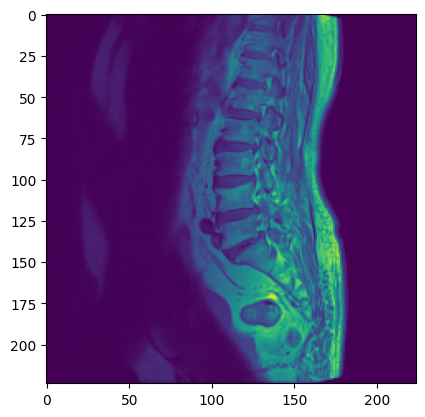

In [14]:
# dcm = pydicom.dcmread('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1002894806/866293114/11.dcm')
# resized_image = cv2.resize( np.array(dcm.pixel_array), (224, 224), interpolation=cv2.INTER_AREA)
# plt.imshow(resized_image)
# plt.show()

## Lumbar Coordinate Dataset


This notebook shows how the [Lumbar Coordinate Dataset](https://www.kaggle.com/datasets/brendanartley/lumbar-coordinate-pretraining-dataset) can be used in the RSNA 2024 competition. First I will showcase improved coordinates for the competition data, and then I will showcase using external data to pretrain backbones.

## 1. Improved RSNA Coordinates


We improve the competition coordinates by labelling the left side of each disc. This gives us the angle of orientation which can be used to improve cropping of each disc.

Thanks to [Ian Pan](https://www.kaggle.com/vaillant) for sharing some helper functions for loading the dicom data. See his great notebook [here](https://www.kaggle.com/code/vaillant/cross-reference-images-in-different-mri-planes?scriptVersionId=182551992&cellId=2).

In [2]:
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x) 
    return (x * 255).astype("uint8")


def load_dicom_stack(dicom_folder, plane, reverse_sort=False):
    dicom_files = glob.glob(os.path.join(dicom_folder, "*.dcm"))
    dicoms = [pydicom.dcmread(f) for f in dicom_files]
    plane = {"sagittal": 0, "coronal": 1, "axial": 2}[plane.lower()]
    positions = np.asarray([float(d.ImagePositionPatient[plane]) for d in dicoms])
    # if reverse_sort=False, then increasing array index will be from RIGHT->LEFT and CAUDAL->CRANIAL
    # thus we do reverse_sort=True for axial so increasing array index is craniocaudal
    idx = np.argsort(-positions if reverse_sort else positions)
    ipp = np.asarray([d.ImagePositionPatient for d in dicoms]).astype("float")[idx]
    array = np.stack([d.pixel_array.astype("float32") for d in dicoms])
    array = array[idx]
    return {"array": convert_to_8bit(array), "positions": ipp, "pixel_spacing": np.asarray(dicoms[0].PixelSpacing).astype("float")}

image_dir = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/"

In [3]:
resize_transform= A.Compose([
    A.LongestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC, always_apply=True),
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0), always_apply=True),
])

def angle_of_line(x1, y1, x2, y2):
    return math.degrees(math.atan2(-(y2-y1), x2-x1))

def plot_img(img, coords_temp):
    # Plot img
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    h, w = img.shape
    
    # Kepoints as pairs
    #p= coords_temp.groupby("level") \
                 # .apply(lambda g: list(zip(g['relative_x'], g['relative_y'])), include_groups=False) \
                 # .reset_index(drop=False, name="vals")
    
    print("plot-img")
    for i in range(0, len(coords_temp), 4):
        category = coords_temp[i:i+4]  # Extracting 4 elements at a time
        x= [category[0]*w,category[2]*w]
        y= [category[1]*h,category[3]*h]
        ax.plot(x, y, marker='o')
    ax.axis('off')
    plt.show()

def plot_5_crops(orientataion,coords_temp,numberOfImageFromCenter = 3):
    # Create a figure and axis for the grid
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 5, width_ratios=[1]*5)
    
    # Plot the crops
    print("plot-5-crop-img")
    middleImage = len(orientataion["array"])//2
    img = orientataion["array"][middleImage]
    
    roi = orientataion["array"][middleImage-numberOfImageFromCenter:middleImage+numberOfImageFromCenter+1]
    croppedImage = []
    #print(p)
    for i in range(0, len(coords_temp), 4):
        # Copy of img
        img_copy= img.copy()
        h, w = img.shape
        roi_copy = roi.copy()
        # Extract Keypoints
        category = coords_temp[i:i+4]  # Extracting 4 elements at a time
        a= (category[0]*w, category[1]*h)
        b= (category[2]*w, category[3]*h)
        
        # Rotate
        rotate_angle= angle_of_line(a[0], a[1], b[0], b[1])
        transform = A.Compose([
            A.Rotate(limit=(-rotate_angle, -rotate_angle), p=1.0),
        ], keypoint_params= A.KeypointParams(format='xy', remove_invisible=False),
        )

        t= transform(image=img_copy, keypoints=[a,b])
        img_copy= t["image"]
        a,b= t["keypoints"]
        
        # Crop + Resize
        img_copy,roi_copy = crop_between_keypoints(roi_copy,img_copy, a, b)
        roi_copy_list  = []
        for j in range (0,numberOfImageFromCenter*2+1):
            roi_copy_list.append(resize_transform(image=roi_copy[j])["image"])
        roi_copy_list = np.array(roi_copy_list)
        
        img_copy = roi_copy_list[numberOfImageFromCenter]
        croppedImage.append(roi_copy_list)
        # Plot
        ax = plt.subplot(gs[i//4])
        ax.imshow(img_copy, cmap='gray')
        ax.set_title(f"L{i//4+1}")
        ax.axis('off')
    plt.show()
    return np.array(croppedImage)
    
def crop_between_keypoints(roi,img, keypoint1, keypoint2):
    h, w = img.shape
    x1, y1 = int(keypoint1[0]), int(keypoint1[1])
    x2, y2 = int(keypoint2[0]), int(keypoint2[1])
    
    # Calculate bounding box around the keypoints
    left = int(min(x1, x2) - (w * 0.1))
    right = int(max(x1, x2) + (w * 0.1))
    top = int(min(y1, y2) - (h * 0.07))
    bottom = int(max(y1, y2) + (h * 0.1))
            
    # Crop the image
    return img[top:bottom, left:right],roi[:,top:bottom, left:right]

In [4]:
def plot_axial(axial_images_level):
    first_channel_images = axial_images_level[:, 0, :, :]

    # Number of images
    num_images = first_channel_images.shape[0]

    # Create subplots with 1 row and 5 columns
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))  # Create a figure with 1 row and 5 columns

    # Display each image in the first channel in a subplot
    for i in range(num_images):
        axs[i].imshow(first_channel_images[i], cmap='gray')  # Use 'gray' for single channel
        axs[i].set_title(f'Image {i + 1} - First Channel')
        axs[i].axis('off')  # Hide axes

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the subplot

In [7]:
def prepare_level_wise_axial(sagittal_img, imgsag_y_coord_to_axial_slice, coordinates,no_of_axial_slice = 3):
    h, w = sagittal_img.shape
    axial_list = []
    
    first_key = next(iter(imgsag_y_coord_to_axial_slice))
    # Get the first value
    first_value = imgsag_y_coord_to_axial_slice[first_key]

    keys = list(imgsag_y_coord_to_axial_slice.keys())
    keys.sort()

    for i in range(0, len(coordinates), 4):
        #print(i)
        category = coordinates[i:i+4]  # Extracting 4 elements at a time
        y= [category[1]*h,category[3]*h]
        minimum = math.floor(min(y[0],y[1]))
        maximum  = math.ceil(max(y[0],y[1]))
        filtered_keys = [k for k in imgsag_y_coord_to_axial_slice.keys() if minimum <= k <= maximum]
        
        if len(filtered_keys) >= no_of_axial_slice:
            # Use numpy to select 3 keys at uniform intervals
            selected_keys = np.linspace(0, len(filtered_keys)-1,no_of_axial_slice , dtype=int)
            selected_keys = [filtered_keys[i] for i in selected_keys]
        else:
            if len(filtered_keys) == 0:
                index = bisect.bisect_left(keys, minimum)
                # Check if we can find a nearest value less than current_value
                if index > 0:
                    filtered_keys.append(keys[index - 1])

                index = bisect.bisect_right(keys, maximum)
                if index < len(keys):
                    filtered_keys.append(keys[index])  # Return the nearest value greater than current_value
                    

            filtered_keys.extend([filtered_keys[-1]] * (no_of_axial_slice - len(filtered_keys)))
            selected_keys = filtered_keys
        
        if len(selected_keys) ==  0:
            result  = np.zeros((no_of_axial_slice, first_value.shape[0],first_value.shape[1]))
        else:
            selected_axial =[imgsag_y_coord_to_axial_slice.get(k) for k in selected_keys]
            result  = np.array(selected_axial)

        roi_copy_list  = []
        for j in range(result.shape[0]):
            roi_copy_list.append(resize_transform(image=result[j])["image"])
            
        axial_list.append(np.array(roi_copy_list))
        
    return  np.array(axial_list)

# No. of duplicate axial

In [20]:
# # grouped_df = dfd.groupby(['study_id', 'series_description']).filter(lambda x: len(x) > 1)
# grouped_df['series_description'].unique()
# grouped_df[grouped_df['series_description'] == "Axial T2" ].info()

-------------------------  STUDY_ID: 1667735473, SERIES_ID: 3194845181  -------------------------
<class 'numpy.ndarray'>
(21, 576, 576)
plot-img


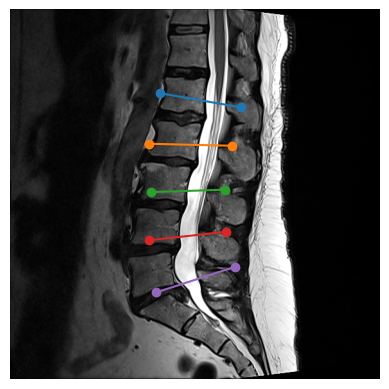

plot-5-crop-img


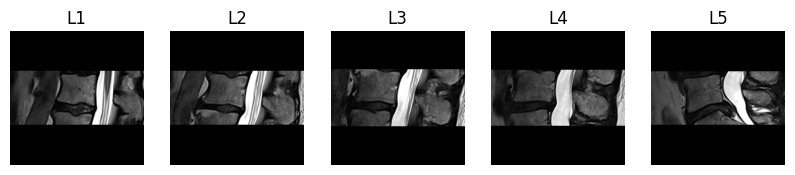

(5, 3, 256, 256)


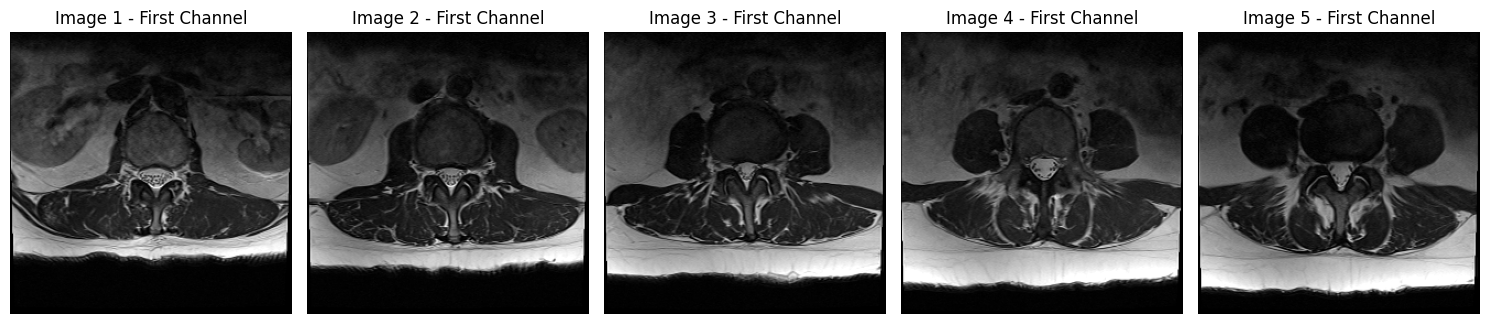

(5, 3, 256, 256)
slice from mid 0
plot-img


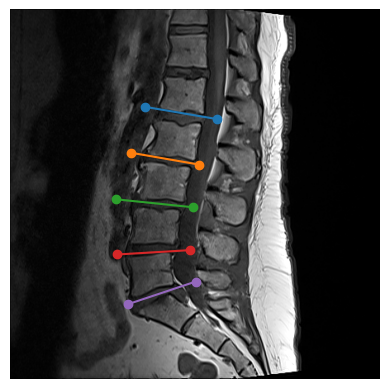

plot-5-crop-img


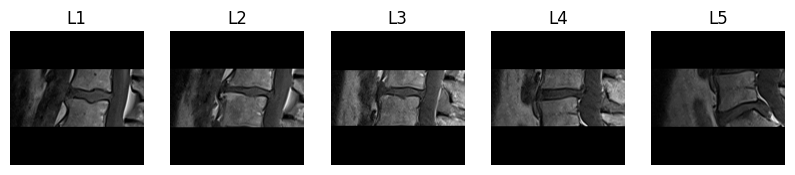

(5, 9, 256, 256)


In [9]:
SEED= 10
N= 1

# Load series_ids
dfd= pd.read_csv("/kaggle/input/point-predict-val-test-dataset/val_df_data.csv")
dfd = dfd[['study_id',"series_id"]].drop_duplicates().reset_index(drop=True)

#Add code to load axia csv and then images
dfs  = pd.read_csv("/kaggle/input/point-predict-val-test-dataset/val_df_studyId.csv")
dfddm = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")
dfsd = pd.merge(dfs,dfddm,on=['study_id'],how="inner")
dfsd = dfsd[dfsd["series_description"] == "Axial T2"]
dfsd = dfsd.drop_duplicates(subset=['study_id']).reset_index(drop=True)

# Code to load and predict Sagital T1 Images
dfsd1 = pd.merge(dfs,dfddm,on=['study_id'],how="inner")
dfsd1 = dfsd1[dfsd1["series_description"] == "Sagittal T1"]
dfsd1 = dfsd1.drop_duplicates(subset=['study_id']).reset_index(drop=True)

#dfd= dfd[dfd.series_description == "Sagittal T2/STIR"]
dfd= dfd.head(N)

# Load coords
coords= pd.read_csv("/kaggle/input/point-predict-val-test-dataset/predicted_cordinates_val.csv")
coords_t1 = pd.read_csv("/kaggle/input/point-predict-val-test-dataset/predicted_cordinates_sag_t1.csv")
#coords= coords.sort_values(["series_id", "level", "side"]).reset_index(drop=True)
#coords= coords[["series_id", "level", "side", "relative_x", "relative_y"]]

# Plot samples
for idx, row in dfd.iterrows():
    try:
        print("-"*25, " STUDY_ID: {}, SERIES_ID: {} ".format(row.study_id, row.series_id), "-"*25)
        sag_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="sagittal")
        
        axial_series_id = dfsd[dfsd['study_id'] == row.study_id].iloc[0].series_id
        ax_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(axial_series_id)), plane="axial", reverse_sort=True)

        #Sagital T1
        sag_t1_id = dfsd1[dfsd1['study_id'] == row.study_id].iloc[0].series_id
        sag_t1 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(sag_t1_id)), plane="sagittal")
        
        # Cross Sectional Images axial
        top_left_hand_corner_sag_t2 = sag_t2["positions"][len(sag_t2["array"]) // 2]
        sag_y_axis_to_pixel_space = [top_left_hand_corner_sag_t2[2]]
        while len(sag_y_axis_to_pixel_space) < sag_t2["array"].shape[1]: 
            sag_y_axis_to_pixel_space.append(sag_y_axis_to_pixel_space[-1] - sag_t2["pixel_spacing"][1])
        
        sag_y_coord_to_axial_slice = {}
        for ax_t2_slice, ax_t2_pos in zip(ax_t2["array"], ax_t2["positions"]):
            diffs = np.abs(np.asarray(sag_y_axis_to_pixel_space) - ax_t2_pos[2])
            sag_y_coord = np.argmin(diffs)
            sag_y_coord_to_axial_slice[sag_y_coord] = ax_t2_slice
        
         # Img + Coords
        #print(len(sag_t2["array"])//2)
        #print(sag_t2["array"].shape[-1])
        print(type(sag_t2["array"]))
        print(sag_t2["array"].shape)
        img= sag_t2["array"][len(sag_t2["array"])//2]
        coords_temp= coords.iloc[idx].tolist()
        
        corresponding_axial = prepare_level_wise_axial(img, sag_y_coord_to_axial_slice, coords_temp,no_of_axial_slice = 3)
       
        
        # Plot Axial and t2
        plot_img(img, coords_temp)
        
        crop_result_t2 = plot_5_crops(sag_t2, coords_temp,numberOfImageFromCenter = 1)
        print(crop_result_t2.shape)

        plot_axial(corresponding_axial)
       # corresponding_axial = np.transpose(corresponding_axial,(0,3,1,2))
        print(corresponding_axial.shape)

        # plot T1
        for i in range(0, 1):
            print("slice from mid",i)
            img= sag_t1["array"][len(sag_t1["array"])//2 +i ]
            coords_t1_temp= coords_t1.iloc[idx].tolist()
            plot_img(img, coords_t1_temp)
            crop_result = plot_5_crops(sag_t1, coords_t1_temp,numberOfImageFromCenter = 4)
            print(crop_result.shape)
    except Exception as e:
        print(e)
        pass

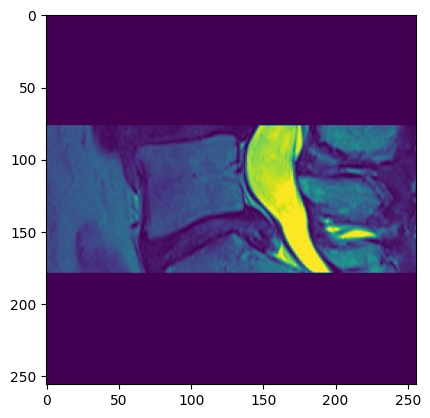

In [134]:
plt.imshow(crop_result_t2[4,1,:,:])
plt.show()

# Testinng Crop functions

In [37]:
orientataion = sag_t1
coords_temp = coords_t1_temp

In [38]:
middleImage = len(orientataion["array"])//2
img = orientataion["array"][middleImage]

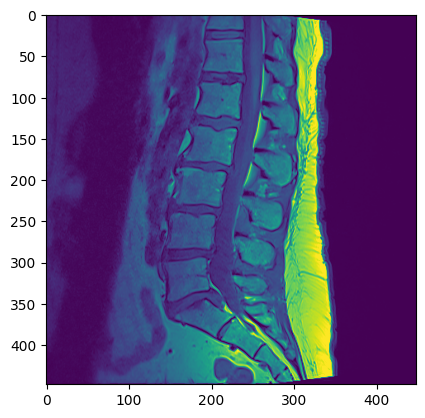

In [40]:
plt.imshow(img)
plt.show()

In [44]:
numberOfImageFromCenter = 4

In [56]:
croppedImage = []
#print(p)
for i in range(0, len(coords_temp), 4):
    # Copy of img
    img_copy= img.copy()
    h, w = img.shape
    roi = orientataion["array"][middleImage-numberOfImageFromCenter:middleImage+numberOfImageFromCenter]
    # Extract Keypoints
    category = coords_temp[i:i+4]  # Extracting 4 elements at a time
    a= (category[0]*w, category[1]*h)
    b= (category[2]*w, category[3]*h)
    #print(a)
   # print(b)

    # Rotate
    rotate_angle= angle_of_line(a[0], a[1], b[0], b[1])
    transform = A.Compose([
        A.Rotate(limit=(-rotate_angle, -rotate_angle), p=1.0),
    ], keypoint_params= A.KeypointParams(format='xy', remove_invisible=False),
    )

    t= transform(image=img_copy, keypoints=[a,b])
    img_copy= t["image"]
    a,b= t["keypoints"]

    # Crop + Resize
    img_copy,roi = crop_between_keypoints(roi,img_copy, a, b)

    roi_copy  = []
    for i in range (0,numberOfImageFromCenter*2):
        roi_copy.append(resize_transform(image=roi[i])["image"])
    roi_copy = np.array(roi_copy)
    croppedImage.append(roi_copy)

s = np.array(croppedImage)


In [57]:
s.shape

(5, 8, 256, 256)

In [57]:
dfd= pd.read_csv("/kaggle/input/point-predict-val-test-dataset/val_df_data.csv")
dfds = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")

In [63]:
dfd.head(1)

,study_id,Unnamed: 0,series_id,relative_x,relative_y,condition,side,instance_number,level,series_description
0,1667735473,43244,3194845181,0.355469,0.28125,Spinal Canal Stenosis,L,-1,L1/L2,Sagittal T2/STIR


In [59]:
dfsd[dfsd['study_id'] == 1667735473]

,study_id,series_id,series_description
0,1667735473,2241579220,Axial T2


In [65]:
dfs  = pd.read_csv("/kaggle/input/point-predict-val-test-dataset/val_df_studyId.csv")

In [64]:
coords= pd.read_csv("/kaggle/input/point-predict-val-test-dataset/predicted_cordinates_val.csv")

In [67]:
sag_t2 = load_dicom_stack(os.path.join(image_dir, str(1667735473), str(3194845181)), plane="sagittal")
ax_t2 = load_dicom_stack(os.path.join(image_dir, str(1667735473), str(2241579220)), plane="axial", reverse_sort=True)

Feel free to change the seed, or increase N to see more samples.

In [68]:
top_left_hand_corner_sag_t2 = sag_t2["positions"][len(sag_t2["array"]) // 2]
sag_y_axis_to_pixel_space = [top_left_hand_corner_sag_t2[2]]
while len(sag_y_axis_to_pixel_space) < sag_t2["array"].shape[1]: 
    sag_y_axis_to_pixel_space.append(sag_y_axis_to_pixel_space[-1] - sag_t2["pixel_spacing"][1])

sag_y_coord_to_axial_slice = {}
for ax_t2_slice, ax_t2_pos in zip(ax_t2["array"], ax_t2["positions"]):
    diffs = np.abs(np.asarray(sag_y_axis_to_pixel_space) - ax_t2_pos[2])
    sag_y_coord = np.argmin(diffs)
    sag_y_coord_to_axial_slice[sag_y_coord] = ax_t2_slice

In [69]:
img= sag_t2["array"][len(sag_t2["array"])//2]
coords_temp= coords.iloc[0].tolist()

In [96]:
h, w = img.shape


In [75]:
first_key = next(iter(sag_y_coord_to_axial_slice))
# Get the first value
first_value = sag_y_coord_to_axial_slice[first_key]

In [135]:
no_of_axial_slice = 3 

In [161]:
axial_list = []
keys = list(sag_y_coord_to_axial_slice.keys())
keys.sort()
for i in range(0, len(coords_temp), 4):
        print(i)
        category = coords_temp[i:i+4]  # Extracting 4 elements at a time
        y= [category[1]*h,category[3]*h]
        minimum = math.floor(min(y[0],y[1]))
        maximum  = math.ceil(max(y[0],y[1]))
        print("minimum:",minimum)
        print("maximum:",maximum)
        filtered_keys = [k for k in sag_y_coord_to_axial_slice.keys() if minimum <= k <= maximum]
        
        print("Filtered keys")
        print(filtered_keys)
        if len(filtered_keys) >= no_of_axial_slice:
            # Use numpy to select 3 keys at uniform intervals
            selected_keys = np.linspace(0, len(filtered_keys)-1, no_of_axial_slice, dtype=int)
            selected_keys = [filtered_keys[i] for i in selected_keys]
        else:
            if len(filtered_keys) == 0:
                index = bisect.bisect_left(keys, minimum)
                # Check if we can find a nearest value less than current_value
                if index > 0:
                    filtered_keys.append(keys[index - 1])
               
                index = bisect.bisect_right(keys, maximum)
                if index < len(keys):
                    filtered_keys.append(keys[index])  # Return the nearest value greater than current_value
            
            filtered_keys.extend([filtered_keys[-1]] * (no_of_axial_slice - len(filtered_keys)))
            selected_keys = filtered_keys
        
        print(selected_keys)
        if len(selected_keys) ==  0:
            axial_list.append(np.zeros((first_value.shape[0],first_value.shape[1] , no_of_axial_slice)))
        else:
            selected_axial =[sag_y_coord_to_axial_slice.get(k) for k in selected_keys]
            result  = np.array(selected_axial)
            print(result.shape)
            result = np.transpose(result, (1, 2, 0))
            print(result.shape)
            axial_list.append(result)

0
minimum: 130
maximum: 153
Filtered keys
[133, 143, 153]
[133, 143, 153]
(3, 448, 448)
(448, 448, 3)
4
minimum: 208
maximum: 212
Filtered keys
[211]
[211, 211, 211]
(3, 448, 448)
(448, 448, 3)
8
minimum: 280
maximum: 285
Filtered keys
[]
[279, 289, 289]
(3, 448, 448)
(448, 448, 3)
12
minimum: 346
maximum: 360
Filtered keys
[]
[318, 366, 366]
(3, 448, 448)
(448, 448, 3)
16
minimum: 400
maximum: 441
Filtered keys
[405, 415, 424, 434]
[405, 415, 434]
(3, 448, 448)
(448, 448, 3)


In [162]:
sag_y_coord_to_axial_slice.keys()

dict_keys([114, 123, 133, 143, 153, 162, 172, 182, 192, 201, 211, 221, 231, 240, 250, 260, 270, 279, 289, 299, 308, 318, 366, 375, 385, 395, 405, 415, 424, 434, 444, 454, 464, 473, 483, 493, 503, 513, 522, 532, 542, 552])

In [163]:
s = np.array(axial_list)

In [169]:
s.shape

(5, 448, 448, 3)

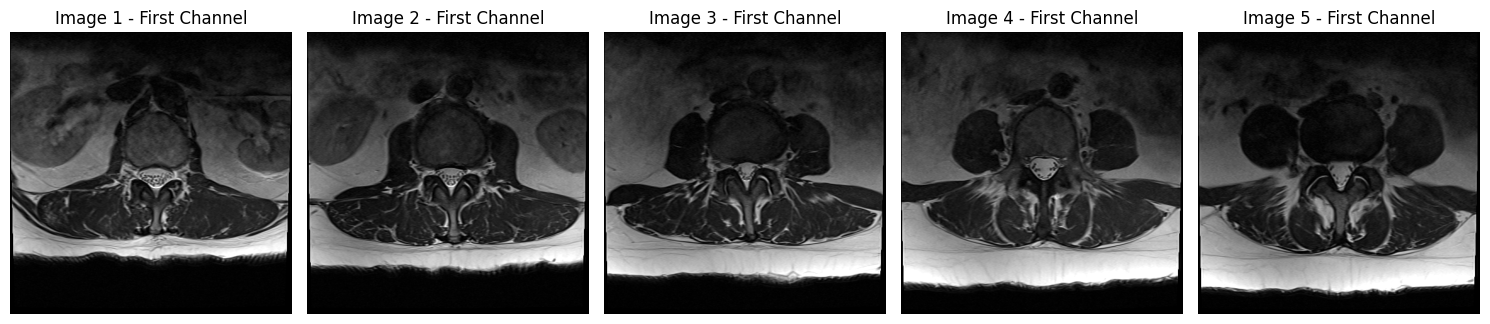

In [170]:
plot_axial(s)

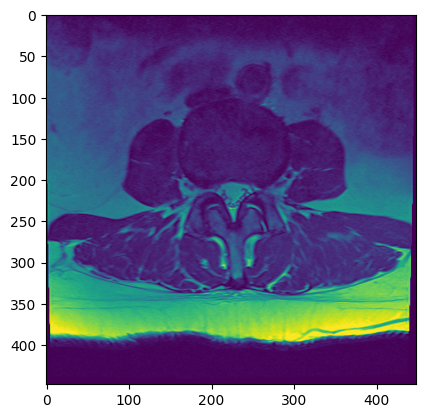

In [165]:
plt.imshow(s[2,:,:,1])
plt.show()

## 2. Pretraining

Next, I show a simple pipeline to train a model to predict the x,y coordinates of the 5 lower lumbar vertabrae. The idea is that we first train our image model on a similar task so that the model better suited to tackle our main objective. 

This data was put together in the first version so it does not include left side coordinates. 

For more information on the data, see [here](https://www.kaggle.com/datasets/brendanartley/lumbar-coordinate-pretraining-dataset).

<h1 align="left">
<img src="https://storage.googleapis.com/kaggle-datasets-images/5464745/9091594/db0b402668602e8a6eb772a162f47eb3/dataset-cover.png?t=2024-08-02-23-33-03" alt="spine_img" width="700">
</h1>


In [2]:
# Config
cfg= SimpleNamespace(
    img_dir= "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images",
    device= torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    n_frames=3,
    epochs=10,
    lr=0.0005,
    batch_size=16,
    backbone="resnet18",
    seed= 0,
)
set_seed(seed=cfg.seed) # Makes results reproducable

In [3]:
# Load metadata

improved_df = pd.read_csv('/kaggle/input/lumbar-coordinate-pretraining-dataset/coords_rsna_improved.csv')
train_series_description= pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')
train_series_description = train_series_description[train_series_description['series_description'] == "Sagittal T2/STIR"]
df  = pd.merge(improved_df, train_series_description, on=['study_id', 'series_id'], how='inner')
#df= pd.read_csv("/kaggle/input/lumbar-coordinate-pretraining-dataset/coords_rsna_improved.csv")
df= df.sort_values(["study_id", "series_id", "level","side"]).reset_index(drop=True)
#df["filename"] = df["filename"].str.replace(".jpg", ".npy")
#df["series_id"] = df["source"] + "_" + df["filename"].str.split(".").str[0]

print("----- IMGS per source -----")
#display((df.study_id.value_counts()/5).astype(int).reset_index())

----- IMGS per source -----


## Dataset

Here we define the torch dataset that will be used during training.

In [4]:
class PreTrainDataset(torch.utils.data.Dataset):
    def __init__(self, study_ids,df ,cfg,transform):
        self.cfg= cfg
        self.records= self.load_coords(df)
        self.study_ids = study_ids
        self.transform = transform

    def load_coords(self, df):
        # Convert to dict
        d = df.groupby(["study_id","series_id"])[["relative_x", "relative_y"]].apply(lambda x: list(x.itertuples(index=False, name=None)))
        records= {}
        for i, (k,v) in enumerate(d.items()):
            records[i]= {"series_id": k, "label": np.array(v).flatten()}
            #print(k)
            #print(len(v))
            assert len(v) == 10
        return records
    
    def convert_to_8bit(self,x):
        lower, upper = np.percentile(x, (1, 99))
        x = np.clip(x, lower, upper)
        x = x - np.min(x)
        x = x / np.max(x) 
        return (x * 255).astype("uint8")


    def load_dicom_stack(self,dicom_folder, plane, reverse_sort=False):
        dicom_files = glob.glob(os.path.join(dicom_folder, "*.dcm"))
        dicoms = [pydicom.dcmread(f) for f in dicom_files]
        plane = {"sagittal": 0, "coronal": 1, "axial": 2}[plane.lower()]
        positions = np.asarray([float(d.ImagePositionPatient[plane]) for d in dicoms])
        # if reverse_sort=False, then increasing array index will be from RIGHT->LEFT and CAUDAL->CRANIAL
        # thus we do reverse_sort=True for axial so increasing array index is craniocaudal
        idx = np.argsort(-positions if reverse_sort else positions)
        ipp = np.asarray([d.ImagePositionPatient for d in dicoms]).astype("float")[idx]
        array = np.stack([d.pixel_array.astype("float32") for d in dicoms])
        array = array[idx]
        return {"array": self.convert_to_8bit(array), "positions": ipp, "pixel_spacing": np.asarray(dicoms[0].PixelSpacing).astype("float")}
    
    def pad_image(self, img):
        n= img.shape[0]
        if n >= self.cfg.n_frames:
            start_idx = (n - self.cfg.n_frames) // 2
            return img[start_idx:start_idx + self.cfg.n_frames,:, :]
        else:
            pad_left = (self.cfg.n_frames - n) // 2
            pad_right = self.cfg.n_frames - n - pad_left
            return np.pad(img, ((pad_left, pad_right),(0,0), (0,0)), 'constant', constant_values=0)
    
    def load_img(self, series_id):
        fname = self.load_dicom_stack(os.path.join(self.cfg.img_dir, str(series_id)), plane="sagittal")
        img= fname["array"]
        img= self.pad_image(img)
        img= np.transpose(img, (1,2, 0))
        img= resize_transform(image=img)["image"]
        img= np.transpose(img, (2, 0, 1))
        img= (img / 255.0)
        return img
        
        
    def __getitem__(self, idx):
        d= self.records[idx]
        label= d["label"]
        study_id,series_id = d["series_id"]
        series_id= "/".join([str(study_id),str(series_id)])      
                
        img= self.load_img(series_id)
        return {
            'img': img, 
            'label': label,
            }
    
    def __len__(self,):
        return len(self.records)
    

resize_transform= A.Compose([
A.LongestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC, always_apply=True),
A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0), always_apply=True),
])

df_test_code  = df.head(20)
unique_df_test_code = df[['study_id']].drop_duplicates().reset_index(drop=True)

ds = PreTrainDataset(unique_df_test_code,df_test_code, cfg,resize_transform)    

# Plot a Single Sample
print("---- Sample Shapes -----")
for k, v in ds[1].items():
    print(k, v.shape)


---- Sample Shapes -----
img (3, 256, 256)
label (20,)


## Utils


Here we have a couple helpers functions. 

The first moves data to the GPU if enabled, the second visualizes predictions during training, and the third loads weights when dealing with mismatched shapes.

In [5]:
def batch_to_device(batch, device, skip_keys=[]):
    batch_dict= {}
    for key in batch:
        if key in skip_keys:
             batch_dict[key]= batch[key]
        else:    
            batch_dict[key]= batch[key].to(device)
    return batch_dict

def visualize_prediction(batch, pred, epoch):
    
    mid= cfg.n_frames//2
    
    # Plot
    for idx in range(1):
    
        # Select Data
        img= batch["img"][idx, mid, :, :].cpu().numpy()*255
        cs_true= batch["label"][idx, ...].cpu().numpy()*256
        cs= pred[idx, ...].cpu().numpy()*256
                
        coords_list = [("TRUE", "lightblue", cs_true), ("PRED", "orange", cs)]
        text_labels = [str(x) for x in range(1,21)]
        
        # Plot coords
        fig, axes = plt.subplots(1, len(coords_list), figsize=(10,4))
        fig.suptitle("EPOCH: {}".format(epoch))
        for ax, (title, color, coords) in zip(axes, coords_list):
            ax.imshow(img, cmap='gray')
            ax.scatter(coords[0::2], coords[1::2], c=color, s=50)
            ax.axis('off')
            ax.set_title(title)

            # Add text labels near the coordinates
            for i, (x, y) in enumerate(zip(coords[0::2], coords[1::2])):
                if i < len(text_labels):  # Ensure there are enough labels
                    ax.text(x + 10, y, text_labels[i], color='white', fontsize=15, bbox=dict(facecolor='black', alpha=0.5))


        fig.suptitle("EPOCH: {}".format(epoch))
        plt.show()
#         plt.close(fig)
    return

def load_weights_skip_mismatch(model, weights_path, device):
    # Load Weights
    state_dict = torch.load(weights_path, map_location=device)
    model_dict = model.state_dict()
    
    # Iter models
    params = {}
    for (sdk, sfv), (mdk, mdv) in zip(state_dict.items(), model_dict.items()):
        if sfv.size() == mdv.size():
            params[sdk] = sfv
        else:
            print("Skipping param: {}, {} != {}".format(sdk, sfv.size(), mdv.size()))
    
    # Reload + Skip
    model.load_state_dict(params, strict=False)
    print("Loaded weights from:", weights_path)

## Model Training

Here we train on all sources except for the spider dataset, which is used for validation.

In [ ]:
# df = df.head(50)

In [6]:
grouped = df.groupby('study_id').size()
counts_less_than_10 = grouped[grouped == 10]
counts_df = counts_less_than_10.reset_index(name='count')
counts_df.columns = ['study_id', 'count']

count_df = counts_df.drop(columns=['count'])
df  = pd.merge(df, count_df, on=['study_id'], how='inner')

In [7]:
# Split the DataFrame into training and validation sets
unique_df = df[['study_id']].drop_duplicates().reset_index(drop=True)
train_df, val_df = train_test_split(unique_df, test_size=0.2, random_state=42)

train_data_df  = pd.merge(train_df, df, on=['study_id'], how='inner')
val_data_df  = pd.merge(val_df, df, on=['study_id'], how='inner')


# Datasets + Dataloaders
train_ds= PreTrainDataset(train_df,train_data_df, cfg,resize_transform)
val_ds= PreTrainDataset(val_df, val_data_df,cfg,resize_transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False)

# # Model
# model = timm.create_model('resnet18', pretrained=True, num_classes=20)
# model = model.to(cfg.device)

# # Loss / Optim
# criterion = nn.MSELoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

In [ ]:
# for epoch in range(cfg.epochs+1):
    
#     # Train Loop
#     loss= torch.tensor([0.]).float().to(cfg.device)
#     if epoch != 0:
#         model= model.train()
#         for batch in tqdm(train_dl):
#             batch = batch_to_device(batch, cfg.device)
#             optimizer.zero_grad()

#             x_out = model(batch["img"].float())
#             x_out = torch.sigmoid(x_out)

#             loss = criterion(x_out, batch["label"].float())
#             loss.backward()
#             optimizer.step()
        
#     # Validation Loop
#     val_loss = 0
#     with torch.no_grad():
#         model = model.eval()
#         for batch in tqdm(val_dl):
#             batch = batch_to_device(batch, cfg.device)

#             pred = model(batch["img"].float())
#             pred = torch.sigmoid(pred)
            
#             val_loss += criterion(pred, batch["label"].float()).item()
#         val_loss /= len(val_dl)
            
#     # Viz
#     visualize_prediction(batch, pred, epoch)           
            
#     print(f"Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")
# print("Training complete...")

## Save

Next, we save the backbone weights.

In [ ]:
# f= "{}_{}.pt".format(cfg.backbone, cfg.seed)
# torch.save(model.state_dict(), f)
# print("Saved weights: {}".format(f))

Finally, the weights can be loaded for a new task (eg. this competition).

# Load model and save prediction for validation

In [8]:
model_path = "/kaggle/input/lumbar_spine_verterbrae_disc-detection/pytorch/1/1/resnet18_0.pt"

In [9]:
# Load backbone for RSNA 2024 task
model = timm.create_model('resnet18', pretrained=True, num_classes=20)
model = model.to(cfg.device)
load_weights_skip_mismatch(model, model_path, cfg.device)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Loaded weights from: /kaggle/input/lumbar_spine_verterbrae_disc-detection/pytorch/1/1/resnet18_0.pt


In [10]:
predictions = []
with torch.no_grad():
        model = model.eval()
        for batch in tqdm(val_dl):
            batch = batch_to_device(batch, cfg.device)

            pred = model(batch["img"].float())
            pred = torch.sigmoid(pred)
            predictions.append(pred)

100%|██████████| 25/25 [02:50<00:00,  6.82s/it]


In [22]:
val_df.to_csv('val_df_studyId.csv',index=False)
val_data_df.to_csv('val_df_data.csv',index=False)

#Unwrap
data_list_cpu = [tensor.cpu().numpy() for tensor in predictions]
combined_data = np.vstack(data_list_cpu)

# Save predicted-co-ordinates
df_cords = pd.DataFrame(combined_data)
df_cords.to_csv("predicted_cordinates_val.csv",index=False)